<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90%E9%9B%86%E6%88%90%E5%AD%B8%E7%BF%92(%E9%87%9D%E5%B0%8D%E5%80%8B%E5%88%A5Y).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
import pandas as pd

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/輕油實驗數據(保留大部份欄位,三個基本規則清洗過).csv')
train.rename(columns={'N+A in Feed':'NA'},inplace=True)

x_columns = ['T10','T50','T90','NA']
y_columns = ['C5NP', 'C5IP', 'C5N', 'C6NP',
       'C6IP', 'C6N', 'C6A', 'C7NP', 'C7IP', 'C7N', 'C7A', 'C8NP', 'C8IP',
       'C8N', 'C8A', 'C9NP', 'C9IP', 'C9N', 'C9A', 'C10NP', 'C10IP', 'C10N',
       'C10A']
train = train[x_columns+y_columns]
X_train = train[x_columns]
y_train = train[y_columns]

In [0]:
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/test_without_outlier.csv')
test.columns = train.columns
X_test = test[x_columns]
y_test = test[y_columns]

In [4]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4521, 4) (170, 4) (4521, 23) (170, 23)


# 特徵工程

In [0]:
def 特徵工程(df):
  df['T90-T50'] = df['T90']-df['T50']
  df['T50-T10'] = df['T50']-df['T10']
  return df

In [6]:
train = 特徵工程(train)
test = 特徵工程(test)
print('加入特徵工程項後目前特徵有:')
x_columns = train.drop(y_columns,axis=1).columns.tolist()
print(x_columns)

加入特徵工程項後目前特徵有:
['T10', 'T50', 'T90', 'NA', 'T90-T50', 'T50-T10']


In [7]:
train.head()

,T10,T50,T90,NA,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,T90-T50,T50-T10
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319,27.3,18.7
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,27.6,18.3
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289,26.8,18.8
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281,24.3,18.2
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,24.1,17.7


In [8]:
test.head()

,T10,T50,T90,NA,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,T90-T50,T50-T10
0,98.6,119.2,146.1,40.133,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597,26.9,20.6
1,105.4,122.2,148.2,32.175,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484,26.0,16.8
2,105.8,122.7,149.2,31.428,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456,26.5,16.9
3,105.4,122.4,147.6,31.390,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449,25.2,17.0
4,105.4,122.6,148.2,32.418,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463,25.6,17.2


In [0]:
High_RMSE_index = ['C6N', 'C7N', 'C8N', 'C8A']

# Ensembling & Stacking models

In [0]:
from sklearn.model_selection import KFold
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, 
                              GradientBoostingRegressor,ExtraTreesRegressor)
from sklearn.svm import SVR
import numpy as np


# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS ,random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

Out-of-Fold Predictions Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

In [0]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [0]:
rf = SklearnHelper(clf=RandomForestRegressor,seed=SEED,params=rf_params)
et = SklearnHelper(clf=ExtraTreesRegressor,seed=SEED,params=et_params)
ada = SklearnHelper(clf=AdaBoostRegressor,seed=SEED,params=ada_params)
gb = SklearnHelper(clf=GradientBoostingRegressor,seed=SEED,params=gb_params)

# define y_name

In [14]:
High_RMSE_index

['C6N', 'C7N', 'C8N', 'C8A']

In [0]:
y_name = 'C6N'

In [16]:
y_train = train[y_name].ravel()
y_test = test[y_name].ravel()

x_train = train[x_columns].values 
x_test = test[x_columns].values

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(4521, 6) (170, 6) (4521,) (170,)


# Output of the First level Predictions

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [17]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost

print("Training is complete")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [18]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,2.589772,2.654719,3.517362,2.438679
1,3.091172,3.005278,3.517362,3.083808
2,2.794150,2.736394,3.517362,2.303332
3,2.785535,2.725557,3.517362,2.068550
4,2.859695,2.906079,3.517362,2.359137


# Correlation Heatmap of the Second Level Training set

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

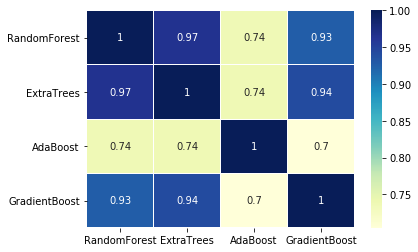

In [19]:
import seaborn as sns
sns.heatmap(abs(base_predictions_train.astype(float).corr()),
            annot=True,
            linewidths=0.1,
            cmap="YlGnBu")

In [0]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

# Second level learning model via XGBoost

In [21]:
import xgboost as xgb

gbm = xgb.XGBRegressor(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[01:03:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [22]:
y_pred_y_test = pd.DataFrame(zip(predictions,y_test),
                             columns=['y_pred','y_test'])
y_pred_y_test.head()

,y_pred,y_test
0,3.477489,4.028
1,2.199838,2.407
2,2.072766,2.296
3,2.125098,2.274
4,2.201356,2.206


# R2 RMSE MAPE

In [0]:
from sklearn.metrics import r2_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def mape(y_true, y_pred,dropinf=True):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ape = np.abs((y_true - y_pred) / y_true)
    if dropinf == True:
      ape = ape[np.isfinite(ape)]
    return np.mean(ape) * 100
def evaluate(y_true,y_pred):
  R2 = r2_score(y_true,y_pred)
  RMSE = rmse(y_true,y_pred)
  MAPE = mape(y_true,y_pred)
  return pd.DataFrame({'R2':R2,
                       'RMSE':RMSE,
                       'MAPE':MAPE    
  },index=[y_name])
  

In [24]:
evaluate(predictions,y_test)

,R2,RMSE,MAPE
C6N,0.768498,0.698902,8.815395
